<a href="https://colab.research.google.com/github/sanjaydinesh19/lstm-footwear-analysis/blob/main/ARIMAX_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
#Configs
"""
Load Libraries and Define detailed Configs
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

CSV_PATH = "/content/drive/MyDrive/Research/Time Series Footwear/data.csv"
DATE_COL = "week_end_date"
TARGET = "units_sold"
GROUP_COLS = ["store_id", "product_id"]
FREQ = "W"
TEST_WEEKS = 6
ORDER = (1,0,4)
SEASONAL_ORDER = (0,0,0,0)
LAG_PERIODS = [1, 2, 4, 8]
ROLLING_WINDOWS = [4, 8]
BASE_EXOG_VARS = [
    "promo_flag",
    "discount_rate",
    "avg_temp_c",
    "rainfall_mm",
    "neighborhood_trend_index",
    "is_festival_season"
]

TOP_K_EXOG = 12
SAVE_MODEL = False
MODEL_PATH = "best_arimax_model.joblib"

In [271]:
def mape(y_true, y_pred):
    """
    Computes Mean Absolute Percentage Error
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def add_lag_features(df, target, lags):
    """
    Adds lagged features to dataframe to capture autoregressive relationships
    """
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    return df

def add_rolling_features(df, target, windows):
    """
    For each window, add rolling mean, std, min, and max to capture trends
    """
    for window in windows:
        df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window).mean()
        df[f'{target}_rolling_std_{window}'] = df[target].rolling(window=window).std()
        df[f'{target}_rolling_min_{window}'] = df[target].rolling(window=window).min()
        df[f'{target}_rolling_max_{window}'] = df[target].rolling(window=window).max()
    return df

def add_interaction_features(df):
    """
    Our own handcrafted interactions and binary flags
    """
    if 'promo_flag' in df.columns and 'discount_rate' in df.columns:
        df['promo_discount'] = df['promo_flag'] * df['discount_rate']
    if 'is_festival_season' in df.columns and 'promo_flag' in df.columns:
        df['festival_promo'] = df['is_festival_season'] * df['promo_flag']
    if 'avg_temp_c' in df.columns and 'rainfall_mm' in df.columns:
        df['temp_rainfall'] = df['avg_temp_c'] * df['rainfall_mm'] / 100.0
    if 'discount_rate' in df.columns:
        df['high_discount'] = (df['discount_rate'] > 0.05).astype(int)
    if 'rainfall_mm' in df.columns:
        df['heavy_rain'] = (df['rainfall_mm'] > 30).astype(int)
    return df

def clean_exog(train_X, test_X):
    """
    Coerce Exogenous Feature matrices to numeric, align columns and drop constants
    1. Convert boolean cols to int
    2. Try numeric coercion for object colums -> If failes, convert categories to codes
    3. Convert everything to numeric
    4. Drop Constants
    5. Keep common to train and test columns
    6. Make sure no non numeric columns remain
    """
    train_X = train_X.copy()
    test_X = test_X.copy()
    bool_cols = train_X.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        train_X[bool_cols] = train_X[bool_cols].astype(int)
        test_X[bool_cols] = test_X[bool_cols].astype(int)
    obj_cols = train_X.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in obj_cols:
        coerced_train = pd.to_numeric(train_X[col], errors='coerce')
        coerced_test = pd.to_numeric(test_X[col], errors='coerce')
        if coerced_train.notna().sum() > 0:
            train_X[col] = coerced_train
            test_X[col] = coerced_test
        else:
            combined = pd.concat([train_X[col].astype('category'), test_X[col].astype('category')], axis=0)
            codes = combined.cat.codes
            train_X[col] = codes.iloc[:len(train_X)].values
            test_X[col] = codes.iloc[len(train_X):].values
    train_X = train_X.apply(pd.to_numeric, errors='coerce')
    test_X  = test_X.apply(pd.to_numeric, errors='coerce')
    train_X = train_X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    test_X  = test_X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    nunique = train_X.nunique()
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        train_X = train_X.drop(columns=const_cols, errors='ignore')
        test_X = test_X.drop(columns=const_cols, errors='ignore')
    common_cols = [c for c in train_X.columns if c in test_X.columns]
    train_X = train_X[common_cols]
    test_X = test_X[common_cols]
    non_numeric = [c for c in train_X.columns if not np.issubdtype(train_X[c].dtype, np.number)]
    if non_numeric:
        raise ValueError(f"Exog still contains non-numeric columns: {non_numeric}")

    return train_X, test_X, common_cols
def add_exog_lags(df, exog_cols, lags):
    """
    Add lagged versions of exogenous columns.
    - df: full group dataframe (sorted by date)
    - exog_cols: iterable of column names to lag (strings)
    - lags: iterable of integer lags (e.g., [1,2])
    Returns df with new columns like 'promo_flag_lag1'.
    """
    for col in exog_cols:
        if col not in df.columns:
            continue
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df


In [272]:
#Drive Mount
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

df = pd.read_csv(CSV_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df = df.dropna(subset=[DATE_COL])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [273]:
#Group Selection
"""
Compute Group Sizes and pick the top (Most Observed) Group. Runs modelling on a single time series
"""
group_counts = df.groupby(GROUP_COLS).size().sort_values(ascending=False)
if group_counts.empty:
    raise ValueError("No groups found in data.")
top_group = group_counts.index[0]
print("Selected group:", top_group, "Observations:", group_counts.iloc[0])

Selected group: ('ST01', 'P001') Observations: 80


In [274]:
#Per Group Preprocessing
"""
1. Filter dataframe for chosen group
2. Add lag, rolling and interaction features
3. Set DATE_COL as idx
4. Use asfreq() to ensure regular weekly frequency
"""
mask = (df[GROUP_COLS[0]] == top_group[0]) & (df[GROUP_COLS[1]] == top_group[1])
gdf = df[mask].copy().sort_values(DATE_COL)

exog_to_lag = [c for c in BASE_EXOG_VARS if c in gdf.columns]
gdf = add_lag_features(gdf, TARGET, LAG_PERIODS)
gdf = add_rolling_features(gdf, TARGET, ROLLING_WINDOWS)
gdf = add_interaction_features(gdf)
gdf = add_exog_lags(gdf, exog_to_lag, lags=[1, 2])
gdf = gdf.set_index(DATE_COL)
y = gdf[TARGET].asfreq(FREQ)

available_exog = [c for c in BASE_EXOG_VARS + list(gdf.columns) if (c in gdf.columns) and (c != TARGET)]

available_exog = list(dict.fromkeys(available_exog))

X = gdf[available_exog].asfreq(FREQ) if available_exog else None

In [275]:
#Handle missing values
if y.isna().any():
    y = y.interpolate(method='time').ffill().bfill().fillna(0)
if X is not None and X.isna().any().any():
    X = X.ffill().bfill().fillna(0)

In [276]:
#Train/Test Split
print(f"Series length: {len(y)}")
valid_idx = y.dropna().index
y = y.loc[valid_idx]
if X is not None:
    X = X.loc[valid_idx]

if len(y) < TEST_WEEKS + 10:
    raise ValueError("Series too short.")

train_y = y.iloc[:-TEST_WEEKS]
test_y  = y.iloc[-TEST_WEEKS:]
train_X = X.iloc[:-TEST_WEEKS] if X is not None else None
test_X  = X.iloc[-TEST_WEEKS:] if X is not None else None

print(f"Train weeks: {len(train_y)}, Test weeks: {len(test_y)}")

Series length: 80
Train weeks: 74, Test weeks: 6


In [277]:
#Feature Selection
"""
Keep only TOP_K_EXOG features using Pearson correlations to reduce dimensionality
"""
if train_X is not None:
    train_X_clean, test_X_clean, feature_names = clean_exog(train_X, test_X)

    if TOP_K_EXOG is not None and TOP_K_EXOG > 0 and len(feature_names) > TOP_K_EXOG:
        corrs = train_X_clean.corrwith(train_y).abs().sort_values(ascending=False)
        top_feats = corrs.index[:TOP_K_EXOG].tolist()
        train_X_clean = train_X_clean[top_feats]
        test_X_clean  = test_X_clean[top_feats]
        feature_names = top_feats
else:
    train_X_clean = test_X_clean = None
    feature_names = []

/tmp/ipython-input-2904854231.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_X = train_X.fillna(method='ffill').fillna(method='bfill').fillna(0)
/tmp/ipython-input-2904854231.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_X  = test_X.fillna(method='ffill').fillna(method='bfill').fillna(0)


In [278]:
#Shape and indices check
if train_X_clean is not None:
    assert train_X_clean.shape[0] == train_y.shape[0], "train_X rows must equal train_y rows"
    assert test_X_clean.shape[0] == test_y.shape[0], "test_X rows must equal test_y rows"
    assert train_X_clean.index.equals(train_y.index)
    assert test_X_clean.index.equals(test_y.index)


In [279]:
#Model Call
print(f"Fitting ARIMAX order={ORDER}")
model = sm.tsa.SARIMAX(
    train_y,
    exog=train_X_clean,
    order=ORDER, #AR = 1, I = 1, MA = 4
    seasonal_order=SEASONAL_ORDER, #No seasonal component
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False, maxiter=200)
n_steps = len(test_y)

Fitting ARIMAX order=(1, 0, 4)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [280]:

#Forecasting and Confidence Intervals
pred_res = res.get_forecast(steps=n_steps, exog=test_X_clean)
forecast = pred_res.predicted_mean
conf_int = pred_res.conf_int()

In [281]:

train_pred = res.fittedvalues                     # Model's in-sample predictions
test_pred = forecast                              # Out-of-sample forecast (already computed)

train_mae = mean_absolute_error(train_y, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
train_mape = mape(train_y, train_pred)
train_accuracy = 100 - train_mape
ss_res_train = np.sum((train_y - train_pred)**2)
ss_tot_train = np.sum((train_y - np.mean(train_y))**2)
train_r2 = 1 - (ss_res_train / ss_tot_train) if ss_tot_train > 0 else np.nan

test_mae = mean_absolute_error(test_y, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))
test_mape = mape(test_y, test_pred)
test_accuracy = 100 - test_mape
ss_res_test = np.sum((test_y - test_pred)**2)
ss_tot_test = np.sum((test_y - np.mean(test_y))**2)
test_r2 = 1 - (ss_res_test / ss_tot_test) if ss_tot_test > 0 else np.nan

print("Training Performance:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  Accuracy: {train_accuracy:.2f}%")
print(f"  R²:   {train_r2:.4f}\n")

print("Testing Performance:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  Accuracy: {test_accuracy:.2f}%")
print(f"  R²:   {test_r2:.4f}")



Training Performance:
  MAE:  2.2538
  RMSE: 2.7458
  MAPE: 11.65%
  Accuracy: 88.35%
  R²:   0.5861

Testing Performance:
  MAE:  2.1521
  RMSE: 3.1833
  MAPE: 17.89%
  Accuracy: 82.11%
  R²:   0.5657


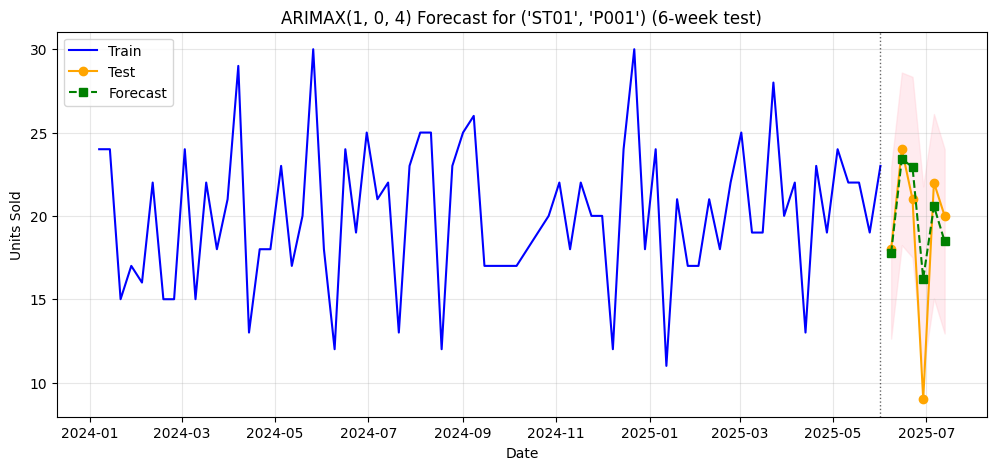

In [282]:
#Visualization plots
plt.figure(figsize=(12,5))
plt.plot(train_y.index, train_y, label='Train', color='blue')
plt.plot(test_y.index, test_y, label='Test', color='orange', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', color='green', marker='s', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.axvline(x=train_y.index[-1], color='k', linestyle=':', linewidth=1, alpha=0.6)
plt.legend()
plt.title(f"ARIMAX{ORDER} Forecast for {top_group} ({TEST_WEEKS}-week test)")
plt.xlabel("Date"); plt.ylabel("Units Sold"); plt.grid(alpha=0.3); plt.show()

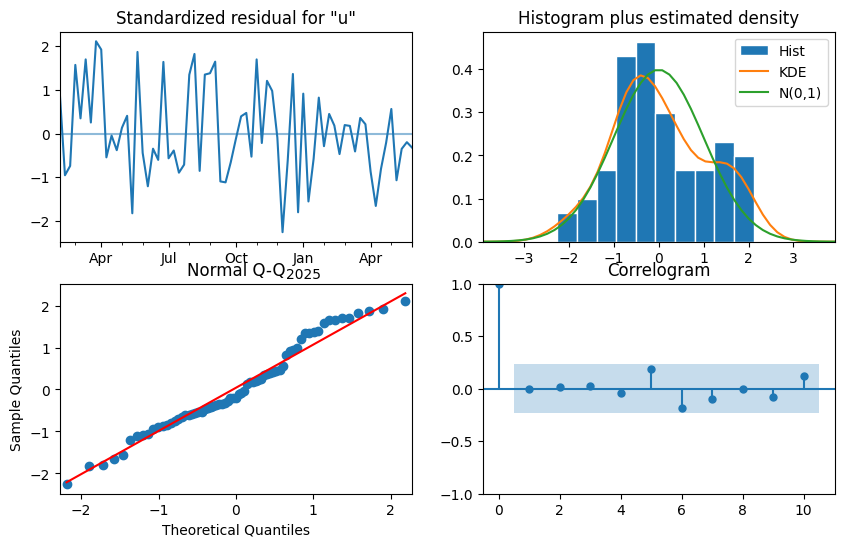

369.2837667868295 409.4976838695802


In [283]:
res.plot_diagnostics(figsize=(10,6))
plt.show()
print(res.aic, res.bic)



In [284]:

#Saving Model
if SAVE_MODEL:
    import joblib
    joblib.dump(res, MODEL_PATH)
    print(f"\nSaved model to {os.path.abspath(MODEL_PATH)}")